# TensorFlow Models

In [1]:
import os
import datetime
import random

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

os.chdir(r'C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels\HelperFunctions')
import auxiliaries as aux
os.chdir(r'C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels')

In [2]:
tf.__version__

'2.16.2'

## Setup

In [3]:
# Develop Testing and Applied Window
species = 'Deer'
file_name = 'GSM02927'

tf_tut_window = aux.WindowGenerator(input_width=aux.OUT_STEPS,
                               label_width=aux.OUT_STEPS,
                               shift=aux.OUT_STEPS,
                               cv_name=f'{species}/{file_name}')

reg_window = aux.RegressiveWindow(f'{species}/{file_name}')
classification_window = aux.ClassificationWindow(f'{species}/{file_name}', 3)
rnn_window = aux.RNNWindow(f'{species}/{file_name}')

results = {}

print(f'{species}:')
print('------Tensorflow Tutorial Window------')
print(f'Original Data Size: {len(tf_tut_window.orig_df)}')
print(f'Training Data Size: {len(tf_tut_window.train_df)}')
print(f'Validation Data Size: {len(tf_tut_window.val_df)}')
print(f'Testing Data Size: {len(tf_tut_window.test_df)}')

print()

print('------Regressive Model Window------')
print(f'Original Data Size: {len(reg_window.orig_df)}')
print(f'Training Data Size: {int(len(reg_window.train_df)*(7/9))}')
print(f'Validation Data Size: {int(len(reg_window.train_df)*(2/9))}')
print(f'Testing Data Size: {len(reg_window.test_df)}')

print()

print('------Classification Model Window------')
print(f'Original Data Size: {len(classification_window.orig_df)}')
print(f'Training Data Size: {int(len(classification_window.train_df)*(7/9))}')
print(f'Validation Data Size: {int(len(classification_window.train_df)*(2/9))}')
print(f'Testing Data Size: {len(classification_window.test_df)}')

Deer:
------Tensorflow Tutorial Window------
Original Data Size: 2923
Training Data Size: 2046
Validation Data Size: 584
Testing Data Size: 293

------Regressive Model Window------
Original Data Size: 2923
Training Data Size: 2046
Validation Data Size: 584
Testing Data Size: 292

------Classification Model Window------
Original Data Size: 2923
Training Data Size: 2046
Validation Data Size: 584
Testing Data Size: 292


## Autoregressive Model

- Good start
- Very inaccurate

In [4]:
autoregressive_model = aux.FeedBack(units=32, out_steps=aux.OUT_STEPS, num_vars=3)

In [5]:
history = aux.compile_and_fit(autoregressive_model, tf_tut_window)

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - loss: 0.9005 - mean_absolute_error: 0.8095 - mean_squared_error: 0.9005 - val_loss: 0.6345 - val_mean_absolute_error: 0.5152 - val_mean_squared_error: 0.6345
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.6113 - mean_absolute_error: 0.5298 - mean_squared_error: 0.6113 - val_loss: 0.6279 - val_mean_absolute_error: 0.4525 - val_mean_squared_error: 0.6279
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5982 - mean_absolute_error: 0.5193 - mean_squared_error: 0.5982 - val_loss: 0.6308 - val_mean_absolute_error: 0.4506 - val_mean_squared_error: 0.6308
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5880 - mean_absolute_error: 0.5138 - mean_squared_error: 0.5880 - val_loss: 0.6926 - val_mean_absolute_error: 0.4672 - val_mean_squared_error: 0.6926


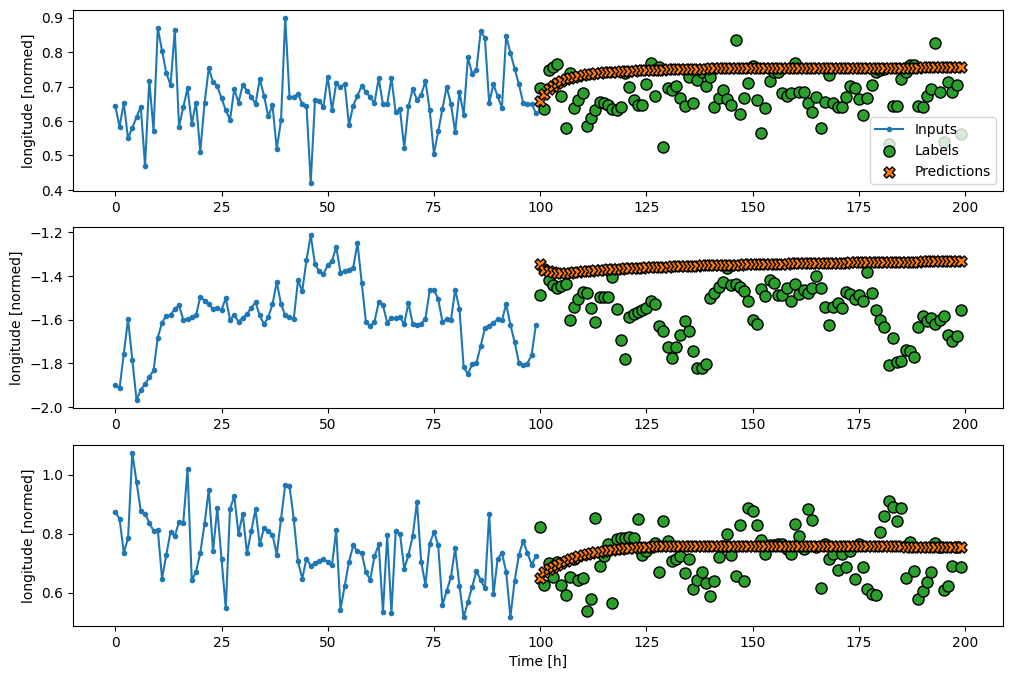

In [6]:
tf_tut_window.plot(autoregressive_model, plot_col='longitude')

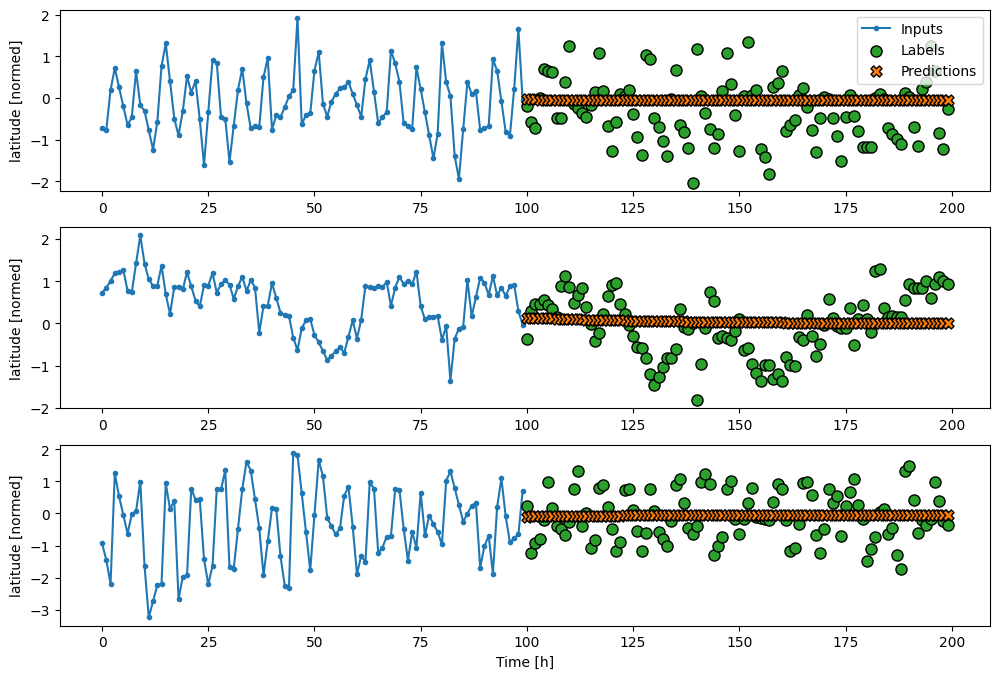

In [7]:
tf_tut_window.plot(autoregressive_model, plot_col='latitude')

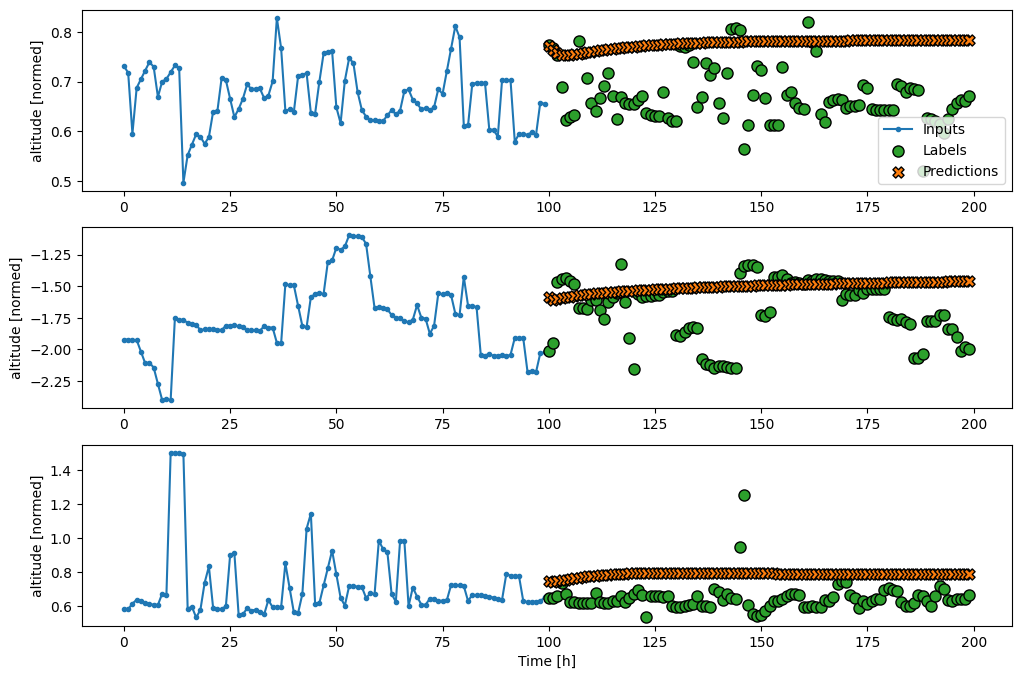

In [8]:
tf_tut_window.plot(autoregressive_model, plot_col='altitude')

In [9]:
results['Autoregressive'] = autoregressive_model.evaluate(tf_tut_window.test, verbose=1, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2780 - mean_absolute_error: 0.3732 - mean_squared_error: 0.2780


In [10]:
autoregressive_model.save(f'ModelCreation/SavedModels/{species}/{file_name}_autoregressive.keras')
tf_tut_window.extend_to_csv(url_dest=f'{species}/{file_name}_autoregressive', species=species, model=autoregressive_model)

In [11]:
def graph_tf_tutorial(model, window, url_dest):
    input_data, label_data = next(iter(window.edge_data))

    predicted_data = pd.DataFrame(model(input_data)[0].numpy(), columns=window.edge_df.columns)*window.train_std + window.train_mean
    input_data = pd.DataFrame(input_data[0].numpy(), columns=window.edge_df.columns)*window.train_std + window.train_mean
    label_data = pd.DataFrame(label_data[0].numpy(), columns=window.edge_df.columns)*window.train_std + window.train_mean

    input_data['timestamp'] = window.date_time.iloc[-(2*aux.OUT_STEPS):-aux.OUT_STEPS].reset_index(drop=True)
    label_data['timestamp'] = window.date_time.iloc[-aux.OUT_STEPS:].reset_index(drop=True)
    predicted_data['timestamp'] = window.date_time.iloc[-aux.OUT_STEPS:].reset_index(drop=True)

    input_data['id'] = ['input' for _ in range(len(input_data))]
    label_data['id'] = ['label' for _ in range(len(label_data))]
    predicted_data['id'] = ['predicted' for _ in range(len(predicted_data))]

    full_df = pd.concat([input_data, label_data, predicted_data], ignore_index=True)
    full_df.to_csv(url_dest, index=False)

    return full_df

autoregressive_model = tf.keras.models.load_model(r'C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels\ModelCreation\SavedModels\Moose\yl1_autoregressive.keras', custom_objects={'FeedBack':aux.FeedBack})

graph_tf_tutorial(autoregressive_model, tf_tut_window, f'TestCSV/{species}/{file_name}_autoregressive_EdgeAnalysis.csv')

,longitude,latitude,altitude,timestamp,id
0,11.000050,46.007557,935.077120,2008-02-10 16:03:10,input
1,10.999269,46.008753,933.640004,2008-02-10 20:03:09,input
2,10.997081,46.007863,931.869999,2008-02-11 00:01:24,input
3,10.998369,46.007551,919.469991,2008-02-11 04:01:52,input
4,10.999782,46.008798,916.259995,2008-02-11 08:03:03,input
...,...,...,...,...,...
295,11.020494,46.010482,1643.474597,2008-03-14 16:00:54,predicted
296,11.020492,46.010470,1644.137705,2008-03-14 20:01:53,predicted
297,11.020490,46.010459,1644.781221,2008-03-15 00:03:05,predicted
298,11.020488,46.010447,1645.404473,2008-03-15 04:02:21,predicted


## RNN Single Shot Model

In [12]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(aux.OUT_STEPS*len(tf_tut_window.column_indices),
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([aux.OUT_STEPS, len(tf_tut_window.column_indices)])
])

history = aux.compile_and_fit(multi_lstm_model, tf_tut_window)

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8942 - mean_absolute_error: 0.8184 - mean_squared_error: 0.8942 - val_loss: 0.6284 - val_mean_absolute_error: 0.4893 - val_mean_squared_error: 0.6284
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5909 - mean_absolute_error: 0.5187 - mean_squared_error: 0.5909 - val_loss: 0.6210 - val_mean_absolute_error: 0.4746 - val_mean_squared_error: 0.6210
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5616 - mean_absolute_error: 0.5013 - mean_squared_error: 0.5616 - val_loss: 0.6063 - val_mean_absolute_error: 0.4842 - val_mean_squared_error: 0.6063
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5439 - mean_absolute_error: 0.4947 - mean_squared_error: 0.5439 - val_loss: 0.6085 - val_mean_absolute_error: 0.5416 - val_mean_squared_error: 0.6085
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.5379 - mean_absolute_error: 0.4985 - mean_squared_error: 0.5379 - val_loss: 0.5852 - val_mean_a

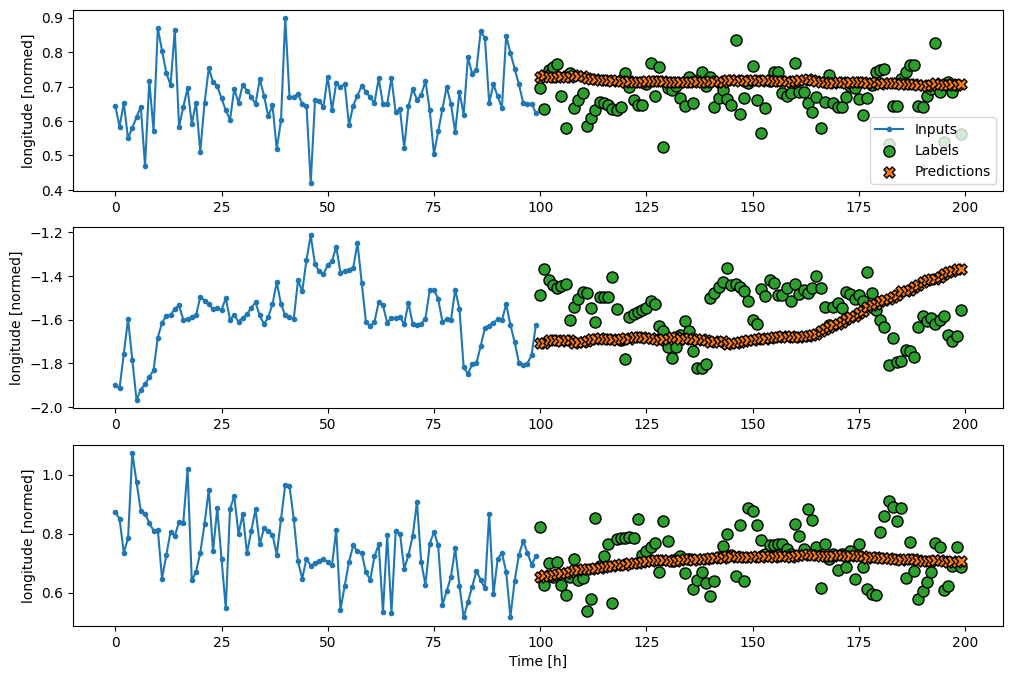

In [13]:
tf_tut_window.plot(multi_lstm_model, plot_col='longitude')

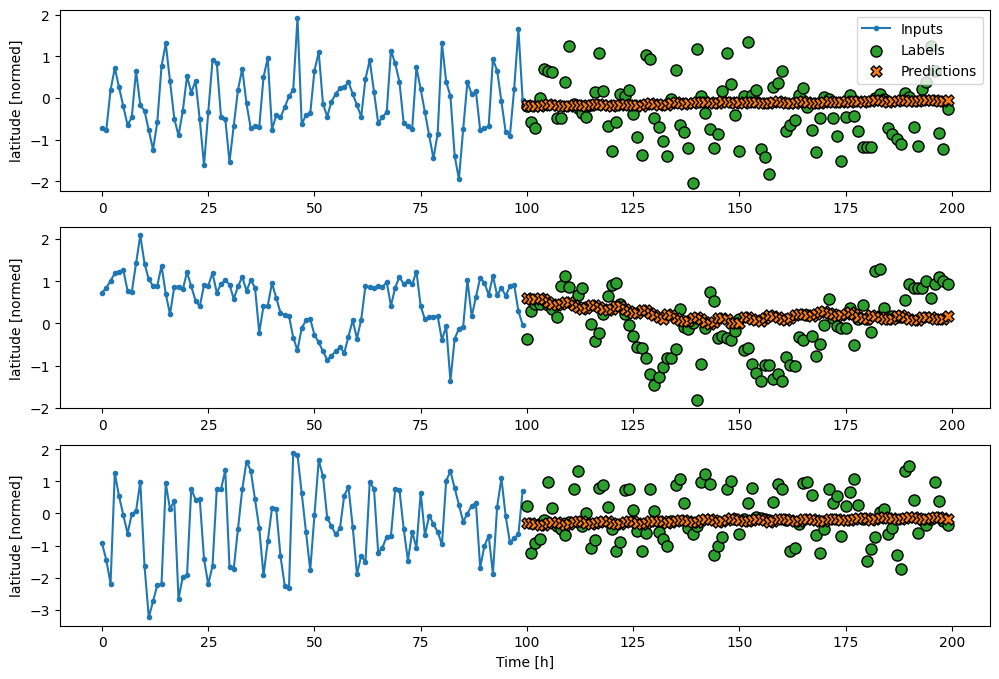

In [14]:
tf_tut_window.plot(multi_lstm_model, plot_col='latitude')

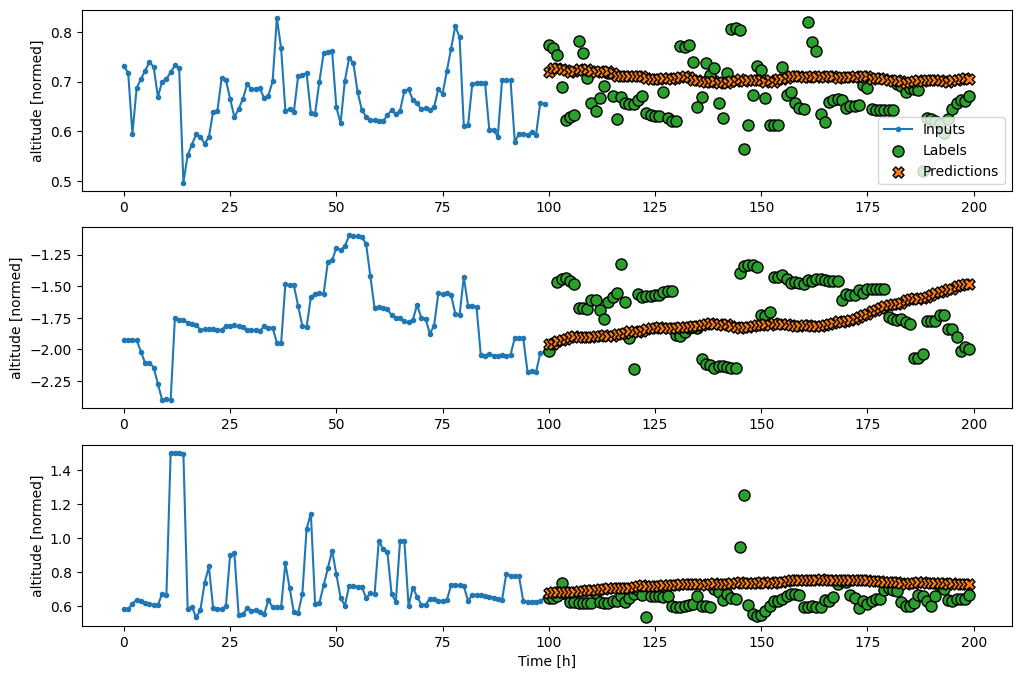

In [15]:
tf_tut_window.plot(multi_lstm_model, plot_col='altitude')

In [16]:
results['Single Shot'] = multi_lstm_model.evaluate(tf_tut_window.test, verbose=1, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3172 - mean_absolute_error: 0.4049 - mean_squared_error: 0.3172 


In [17]:
tf_tut_window.extend_to_csv(url_dest=f'{species}/{file_name}_singleshot', species=species, model=multi_lstm_model)
multi_lstm_model.save(f'ModelCreation/SavedModels/{species}/{file_name}_singleshot.keras')

In [18]:
graph_tf_tutorial(multi_lstm_model, tf_tut_window, f'TestCSV/{species}/{file_name}_singleshot_EdgeAnalysis.csv')

,longitude,latitude,altitude,timestamp,id
0,11.000050,46.007557,935.077120,2008-02-10 16:03:10,input
1,10.999269,46.008753,933.640004,2008-02-10 20:03:09,input
2,10.997081,46.007863,931.869999,2008-02-11 00:01:24,input
3,10.998369,46.007551,919.469991,2008-02-11 04:01:52,input
4,10.999782,46.008798,916.259995,2008-02-11 08:03:03,input
...,...,...,...,...,...
295,11.002598,46.008703,936.157366,2008-03-14 16:00:54,predicted
296,11.002781,46.008621,941.777260,2008-03-14 20:01:53,predicted
297,11.002869,46.008652,944.487289,2008-03-15 00:03:05,predicted
298,11.003057,46.008705,946.641057,2008-03-15 04:02:21,predicted


## Regressive Model

In [19]:
regressive_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=(1,3), activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3)
])

reg_window.model_compilation_and_fitting(regressive_model)

Epoch 1/20


c:\Users\Imper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6944 - mean_absolute_error: 0.6801 - mean_squared_error: 0.6944 - val_loss: 0.5152 - val_mean_absolute_error: 0.5219 - val_mean_squared_error: 0.5152
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5463 - mean_absolute_error: 0.5455 - mean_squared_error: 0.5463 - val_loss: 0.4844 - val_mean_absolute_error: 0.4924 - val_mean_squared_error: 0.4844
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4880 - mean_absolute_error: 0.5041 - mean_squared_error: 0.4880 - val_loss: 0.4550 - val_mean_absolute_error: 0.4684 - val_mean_squared_error: 0.4550
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4883 - mean_absolute_error: 0.4973 - mean_squared_error: 0.4883 - val_loss: 0.4509 - val_mean_absolute_error: 0.5097 - val_mean_squared_error: 0.4509
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4486 - mean_absolute_error: 0.4847 - mean_squared_error: 0.4486 - val_loss: 0.4250 - val_mean_absolute_error: 

In [20]:
regressive_model(reg_window.train_input)*reg_window.train_df[['longitude', 'latitude', 'altitude']].std() + reg_window.train_df[['longitude', 'latitude', 'altitude']].mean()

<tf.Tensor: shape=(2631, 1, 3), dtype=float32, numpy=
array([[[  11.000405,   46.00849 ,  953.4953  ]],

       [[  11.024987,   46.009396, 1266.3737  ]],

       [[  11.012048,   46.007145, 1164.9436  ]],

       ...,

       [[  11.003749,   46.008316,  996.0797  ]],

       [[  11.00375 ,   46.007736,  987.08997 ]],

       [[  11.043539,   46.010593, 1577.0579  ]]], dtype=float32)>

In [21]:
reg_window.train_input.shape

(2631, 1, 3)

In [22]:
results['Regressive Model'] = regressive_model.evaluate(reg_window.test_input, reg_window.test_label, verbose=1, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4500 - mean_absolute_error: 0.4686 - mean_squared_error: 0.4500 


In [23]:
reg_window.csv_extension(f'{species}/{file_name}_regressive', species, regressive_model)

In [24]:
regressive_model.save(f'ModelCreation/SavedModels/{species}/{file_name}_regressive.keras')

In [25]:
def graph_regressive(model, window, url_dest):
    orig_df = window.orig_df
    orig_df['timestamp'] = window.timeline

    initial_df = orig_df.iloc[-aux.OUT_STEPS:][['timestamp', 'month', 'day', 'external-temperature', 'longitude', 'latitude', 'altitude']]
    initial_df['id'] = ['original' for _ in range(len(initial_df))]

    data = {
        'timestamp': [],
        'month': [],
        'day': [],
        'external-temperature': [],
        'longitude': [],
        'latitude': [],
        'altitude': [],
        'id': []
    }

    for i in range(len(initial_df)):
        section = initial_df.iloc[i]

        timestamp = section['timestamp']
        month = section['month']
        day = section['day']
        external_temp = section['external-temperature']

        output_fields = model(np.array([(external_temp - window.train_df.mean()['external-temperature'])/window.train_df.std()['external-temperature'], 
                                        (month - window.train_df.mean()['month'])/window.train_df.std()['month'], 
                                        (day - window.train_df.mean()['day'])/window.train_df.std()['day']]).reshape([1, 1, 3]))*window.train_df[['longitude', 'latitude', 'altitude']].std() + window.train_df[['longitude', 'latitude', 'altitude']].mean()
        output_fields = output_fields.numpy()[0][0]

        longitude = output_fields[0]
        latitude = output_fields[1]
        altitude = output_fields[2]
        id = 'predicted'

        data['timestamp'].append(timestamp)
        data['month'].append(month)
        data['day'].append(day)
        data['external-temperature'].append(external_temp)
        data['longitude'].append(longitude)
        data['latitude'].append(latitude)
        data['altitude'].append(altitude)
        data['id'].append(id)

    add_on_df = pd.DataFrame(data)
    
    full_df = pd.concat([initial_df, add_on_df], ignore_index=True)
    full_df.to_csv(url_dest, index=False)

    return full_df

graph_regressive(regressive_model, reg_window, f'TestCSV/{species}/{file_name}_regressive_EdgeAnalysis.csv')

,timestamp,month,day,external-temperature,longitude,latitude,altitude,id
0,2008-02-27 08:03:04,2,27,12.0,11.000500,46.007768,883.630000,original
1,2008-02-27 12:01:53,2,27,18.0,11.001717,46.007935,883.770000,original
2,2008-02-27 16:03:05,2,27,14.0,11.000832,46.007531,917.374492,original
3,2008-02-27 20:02:47,2,27,14.0,10.999952,46.007130,950.770000,original
4,2008-02-28 00:01:48,2,28,13.0,11.001572,46.008074,952.320000,original
...,...,...,...,...,...,...,...,...
195,2008-03-14 16:00:54,3,14,20.0,11.024459,46.006943,1336.355103,predicted
196,2008-03-14 20:01:53,3,14,10.0,11.025783,46.009674,1338.097412,predicted
197,2008-03-15 00:03:05,3,15,12.0,11.021927,46.009014,1284.197510,predicted
198,2008-03-15 04:02:21,3,15,9.0,11.027290,46.010159,1349.471313,predicted


## RNN Recursive Model

In [26]:
rnn_regressive_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(aux.OUT_STEPS*3,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([aux.OUT_STEPS, 3])
])

rnn_window.model_compilation_and_fitting(rnn_regressive_model)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0283 - mean_absolute_error: 0.8949 - mean_squared_error: 1.0283 - val_loss: 0.7991 - val_mean_absolute_error: 0.7833 - val_mean_squared_error: 0.7991
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8873 - mean_absolute_error: 0.8181 - mean_squared_error: 0.8873 - val_loss: 0.7055 - val_mean_absolute_error: 0.7330 - val_mean_squared_error: 0.7055
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7373 - mean_absolute_error: 0.7014 - mean_squared_error: 0.7373 - val_loss: 0.6911 - val_mean_absolute_error: 0.6740 - val_mean_squared_error: 0.6911
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6527 - mean_absolute_error: 0.6255 - mean_squared_error: 0.6527 - val_loss: 0.7189 - val_mean_absolute_error: 0.6731 - val_mean_squared_error: 0.7189
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6211 - mean_absolute_error: 0.5987 - mean_squared_error: 0.6211 - val_loss: 0.7183 - val_mean_absolu

In [27]:
rnn_window.train_input.shape

(2630, 1, 3)

In [28]:
rnn_window.train_label.shape

(2630, 1, 3)

In [29]:
rnn_regressive_model(rnn_window.train_input)*rnn_window.train_df[['longitude', 'latitude', 'altitude']].std() + rnn_window.train_df[['longitude', 'latitude', 'altitude']].mean()

<tf.Tensor: shape=(2630, 100, 3), dtype=float32, numpy=
array([[[  11.037288,   46.009514, 1479.2584  ],
        [  11.037288,   46.009514, 1479.2584  ],
        [  11.037288,   46.009514, 1479.2584  ],
        ...,
        [  11.037288,   46.009514, 1479.2584  ],
        [  11.037288,   46.009514, 1479.2584  ],
        [  11.037288,   46.009514, 1479.2584  ]],

       [[  11.035105,   46.00964 , 1446.6046  ],
        [  11.035105,   46.00964 , 1446.6046  ],
        [  11.035105,   46.00964 , 1446.6046  ],
        ...,
        [  11.035105,   46.00964 , 1446.6046  ],
        [  11.035105,   46.00964 , 1446.6046  ],
        [  11.035105,   46.00964 , 1446.6046  ]],

       [[  11.034111,   46.00969 , 1431.7902  ],
        [  11.034111,   46.00969 , 1431.7902  ],
        [  11.034111,   46.00969 , 1431.7902  ],
        ...,
        [  11.034111,   46.00969 , 1431.7902  ],
        [  11.034111,   46.00969 , 1431.7902  ],
        [  11.034111,   46.00969 , 1431.7902  ]],

       ...,

    

In [30]:
results['RNN Regressive Model'] = rnn_regressive_model.evaluate(rnn_window.test_input, rnn_window.test_label, verbose=1, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3474 - mean_absolute_error: 0.4580 - mean_squared_error: 0.3474 


In [31]:
rnn_window.csv_extension(f'{species}/{file_name}_RNN_regressive', species, rnn_regressive_model)

In [32]:
rnn_regressive_model.save(f'ModelCreation/SavedModels/{species}/{file_name}_RNN_regressive.keras')

In [33]:
def graph_rnn_regressive(model, window:aux.RNNWindow, url_dest):
    # Isolate OUTSTEP
    initial_df = window.orig_df.iloc[-aux.OUT_STEPS:]
    initial_df['timestamp'] = window.timeline[-aux.OUT_STEPS:]

    # Gather Data
    input_data = (initial_df[['external-temperature', 'month', 'day']] - window.train_df[['external-temperature', 'month', 'day']].mean())/window.train_df[['external-temperature', 'month', 'day']].std()
    predicted_data = model(np.array(input_data.values).reshape((1, aux.OUT_STEPS, 3)))[0]*window.train_df[['longitude', 'latitude', 'altitude']].std() + window.train_df[['longitude', 'latitude', 'altitude']].mean()

    # 
    input_df = initial_df[['timestamp', 'external-temperature', 'month', 'day']].reset_index()
    label_df = pd.DataFrame(predicted_data, columns=['longitude', 'latitude', 'altitude'])

    add_on_df = pd.concat([input_df, label_df], axis=1).drop(columns='index')

    final_df = pd.concat([initial_df, add_on_df], axis=0, ignore_index=True)[['timestamp', 'external-temperature', 'month', 'day', 'longitude', 'latitude', 'altitude']]

    final_df.to_csv(url_dest, index=False)

    return final_df
    

graph_rnn_regressive(rnn_regressive_model, rnn_window, f'TestCSV/{species}/{file_name}_RNN_regressive_EdgeAnalysis.csv')

C:\Users\Imper\AppData\Local\Temp\ipykernel_16976\2497186959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_df['timestamp'] = window.timeline[-aux.OUT_STEPS:]


,timestamp,external-temperature,month,day,longitude,latitude,altitude
0,2008-02-27 08:03:04,12.0,2,27,11.000500,46.007768,883.630000
1,2008-02-27 12:01:53,18.0,2,27,11.001717,46.007935,883.770000
2,2008-02-27 16:03:05,14.0,2,27,11.000832,46.007531,917.374492
3,2008-02-27 20:02:47,14.0,2,27,10.999952,46.007130,950.770000
4,2008-02-28 00:01:48,13.0,2,28,11.001572,46.008074,952.320000
...,...,...,...,...,...,...,...
195,2008-03-14 16:00:54,20.0,3,14,10.981444,46.006832,705.075378
196,2008-03-14 20:01:53,10.0,3,14,10.981444,46.006832,705.075378
197,2008-03-15 00:03:05,12.0,3,15,10.981444,46.006832,705.075378
198,2008-03-15 04:02:21,9.0,3,15,10.981444,46.006832,705.075378


## Classification Model

In [34]:
classification_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=(1, 3), activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(classification_window.n_clusters, activation='softmax'),
])

classification_window.model_compilation_and_fitting(classification_model)

Epoch 1/20


c:\Users\Imper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.2264 - mean_absolute_error: 0.9470 - mean_squared_error: 1.2264 - val_loss: 1.2313 - val_mean_absolute_error: 0.9476 - val_mean_squared_error: 1.2313
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2031 - mean_absolute_error: 0.9347 - mean_squared_error: 1.2031 - val_loss: 1.2313 - val_mean_absolute_error: 0.9476 - val_mean_squared_error: 1.2313
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2661 - mean_absolute_error: 0.9659 - mean_squared_error: 1.2661 - val_loss: 1.2313 - val_mean_absolute_error: 0.9476 - val_mean_squared_error: 1.2313
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2611 - mean_absolute_error: 0.9649 - mean_squared_error: 1.2611 - val_loss: 1.2313 - val_mean_absolute_error: 0.9476 - val_mean_squared_error: 1.2313
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2836 - mean_absolute_error: 0.9742 - mean_squared_error: 1.2836 - val_loss: 1.2313 - val_mean_absolute_error: 0

In [35]:
classification_model(classification_window.test_input)

<tf.Tensor: shape=(292, 1, 3), dtype=float32, numpy=
array([[[0.33354205, 0.33293155, 0.33352634]],

       [[0.33354205, 0.33293155, 0.33352634]],

       [[0.33337453, 0.33378518, 0.33284032]],

       [[0.33310816, 0.33359656, 0.33329538]],

       [[0.33349988, 0.33357918, 0.3329209 ]],

       [[0.33353198, 0.3336777 , 0.3327904 ]],

       [[0.3334816 , 0.33327174, 0.33324665]],

       [[0.3337379 , 0.3333537 , 0.3329084 ]],

       [[0.33329886, 0.33366248, 0.33303866]],

       [[0.33314764, 0.3335    , 0.33335236]],

       [[0.33318764, 0.33349982, 0.33331254]],

       [[0.33306503, 0.33372933, 0.33320564]],

       [[0.33312654, 0.33376154, 0.33311188]],

       [[0.33312654, 0.33376154, 0.33311188]],

       [[0.33287895, 0.3342521 , 0.33286902]],

       [[0.33334154, 0.33456054, 0.33209786]],

       [[0.33292314, 0.33367753, 0.33339924]],

       [[0.33331037, 0.3332586 , 0.33343104]],

       [[0.3331158 , 0.3337733 , 0.33311087]],

       [[0.33322158, 0.3333032 , 0.

In [36]:
results['Classification Model'] = classification_model.evaluate(classification_window.test_input, classification_window.test_label, verbose=1, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3754 - mean_absolute_error: 1.0106 - mean_squared_error: 1.3754 


In [37]:
classification_window.csv_extension(f'{species}/{file_name}_classification', species, classification_model)

C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels\HelperFunctions\auxiliaries.py:403: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['longitude'].append(point[0])
C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels\HelperFunctions\auxiliaries.py:404: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['latitude'].append(point[1])
C:\Users\Imper\OneDrive\Documents\Raul Castillo\College\Year - 2\SMART Program\ComparingModels\HelperFunctions\auxiliaries.py:403: FutureWarning: Series.__getitem__ treating keys as positions is deprec

In [38]:
classification_model.save(f'ModelCreation/SavedModels/{species}/{file_name}_classification.keras')

In [39]:
def graph_classifcation(model, window, url_dest):
    orig_df = window.orig_df
    orig_df['timestamp'] = window.timeline

    initial_df = orig_df.iloc[-aux.OUT_STEPS:][['timestamp', 'month', 'day', 'external-temperature', 'longitude', 'latitude', 'altitude']]
    initial_df['id'] = ['original' for _ in range(len(initial_df))]
    initial_df['label'] = window.k_means.predict(initial_df[['longitude', 'latitude']].values)

    data = {
        'timestamp': [],
        'month': [],
        'day': [],
        'external-temperature': [],
        'longitude': [],
        'latitude': [],
        'altitude': [],
        'label': [],
        'id': []
    }

    for i in range(len(initial_df)):
        section = initial_df.iloc[i]

        timestamp = section['timestamp']
        month = section['month']
        day = section['day']
        external_temp = section['external-temperature']

        output_field = model(np.array([(external_temp - window.train_df.mean()['external-temperature'])/window.train_df.std()['external-temperature'],
                                        (month - window.train_df.mean()['month'])/window.train_df.std()['month'],
                                        (day - window.train_df.mean()['day'])/window.train_df.std()['day']]).reshape((1, 1, 3)))
        
        label = max(range(window.n_clusters), key = lambda x: output_field[0][0][x])
        point = window.clusters[label]*window.train_df[['longitude', 'latitude']].std() + window.train_df[['longitude', 'latitude']].mean()
        
        data['timestamp'].append(timestamp)
        data['longitude'].append(point[0])
        data['latitude'].append(point[1])
        data['altitude'].append(window.altitude_model.predict([point])[0]*window.train_df.std()['altitude'] + window.train_df.mean()['altitude'])
        data['external-temperature'].append(external_temp)
        data['month'].append(month)
        data['day'].append(day)
        data['label'].append(label)
        data['id'].append('predicted')
    
    add_on_df = pd.DataFrame(data)

    full_df = pd.concat([initial_df, add_on_df], ignore_index=True)

    full_df.to_csv(url_dest, index=False)

    return full_df

graph_classifcation(classification_model, classification_window, f'TestCSV/{species}/{file_name}_classification_EdgeAnalysis.csv')

C:\Users\Imper\AppData\Local\Temp\ipykernel_16976\2968565651.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['longitude'].append(point[0])
C:\Users\Imper\AppData\Local\Temp\ipykernel_16976\2968565651.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['latitude'].append(point[1])
C:\Users\Imper\AppData\Local\Temp\ipykernel_16976\2968565651.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['longitude'].append(

,timestamp,month,day,external-temperature,longitude,latitude,altitude,id,label
0,2008-02-27 08:03:04,2,27,12.0,11.000500,46.007768,883.630000,original,0
1,2008-02-27 12:01:53,2,27,18.0,11.001717,46.007935,883.770000,original,0
2,2008-02-27 16:03:05,2,27,14.0,11.000832,46.007531,917.374492,original,0
3,2008-02-27 20:02:47,2,27,14.0,10.999952,46.007130,950.770000,original,0
4,2008-02-28 00:01:48,2,28,13.0,11.001572,46.008074,952.320000,original,0
...,...,...,...,...,...,...,...,...,...
195,2008-03-14 16:00:54,3,14,20.0,11.045946,46.010765,1608.992000,predicted,0
196,2008-03-14 20:01:53,3,14,10.0,11.045946,46.010765,1608.992000,predicted,0
197,2008-03-15 00:03:05,3,15,12.0,11.045374,46.007034,1608.992000,predicted,1
198,2008-03-15 04:02:21,3,15,9.0,11.045946,46.010765,1608.992000,predicted,0


In [40]:
def graph_clusters(window:aux.ClassificationWindow, url_dest):
    orig_df = window.orig_df
    orig_df['timestamp'] = window.timeline

    input_val = (orig_df[['longitude', 'latitude']] - orig_df[['longitude', 'latitude']].mean())/orig_df[['longitude', 'latitude']].std()

    orig_df['label'] = window.k_means.predict(input_val.values)
    clusters = window.clusters*window.train_df[['longitude', 'latitude']].std().values + window.train_df[['longitude', 'latitude']].mean().values
    orig_df['label'] = orig_df['label'].map(lambda x: str(clusters[x]))

    orig_df = orig_df[['timestamp', 'external-temperature', 'month', 'day', 'longitude', 'latitude', 'altitude', 'label']]

    orig_df.to_csv(url_dest, index=False)
    
    return orig_df

graph_clusters(classification_window, f'TestCSV/{species}/{file_name}_classification_clustering_groups.csv')

,timestamp,external-temperature,month,day,longitude,latitude,altitude,label
0,2006-11-12 12:03:04,11.0,11,12,11.048721,46.011148,1607.81,[11.04594625 46.01076535]
1,2006-11-12 16:03:04,9.0,11,12,11.048721,46.011148,1607.81,[11.04594625 46.01076535]
2,2006-11-12 20:03:04,8.0,11,12,11.048721,46.011148,1607.81,[11.04594625 46.01076535]
3,2006-11-13 00:02:24,6.0,11,13,11.048721,46.011148,1607.81,[11.04594625 46.01076535]
4,2006-11-13 04:01:23,2.0,11,13,11.045284,46.012401,1603.96,[11.04594625 46.01076535]
...,...,...,...,...,...,...,...,...
2918,2008-03-14 16:00:54,20.0,3,14,11.056188,46.008492,1521.79,[11.04537387 46.0070341 ]
2919,2008-03-14 20:01:53,10.0,3,14,11.054483,46.008365,1549.28,[11.04537387 46.0070341 ]
2920,2008-03-15 00:03:05,12.0,3,15,11.057391,46.009090,1549.37,[11.04594625 46.01076535]
2921,2008-03-15 04:02:21,9.0,3,15,11.056060,46.007830,1548.38,[11.04537387 46.0070341 ]


## Final Results

In [41]:
results_df = pd.DataFrame(results).T
results_df.to_csv(f'ModelCreation/results/{species}/{file_name}_test_data.csv', index_label='Model_Name')
results_df

,loss,mean_absolute_error,mean_squared_error
Autoregressive,0.279360,0.375001,0.279360
Single Shot,0.316802,0.403838,0.316802
Regressive Model,0.429138,0.450216,0.429138
RNN Regressive Model,0.473292,0.554166,0.473292
Classification Model,1.220700,0.936073,1.220700
